In [10]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = cycler(plt.rcParams["axes.prop_cycle"])
ls_cycler = cycler(ls=["-", "--", "-.", ":"])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

In [3]:
filepath = ft.generate_file_path("h5py", "transmon_floquet", "out")

# EC = 0.1916
# EJ = 10.925


# E_osc = 7.425 # negative detuning from the transmon frequency in GHz
# E_osc = 5.3 # positive

EC = 0.1924
EJ = 18.86
E_osc = 7.243
chi = 0.

# Transmon parameters
num_states = 20
# These parameters give a transmon with E10 = 5.45 GHz, alpha = -219 MHz
qubit_params = {"EJ": EJ, "EC": EC, "ng": 0.0, "ncut": 41}
tmon = scq.Transmon(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]  # get data for ground and first excited states


# Express operators in eigenbasis of transmon
def get_H0_H1(qubit_instance: scq.GenericQubit) -> tuple[qt.Qobj, qt.Qobj]:
    hilbert_space = scq.HilbertSpace([qubit_instance])
    hilbert_space.generate_lookup()
    evals = hilbert_space["evals"][0][0:num_states]
    H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
    H1 = hilbert_space.op_in_dressed_eigenbasis(qubit_instance.n_operator)
    return H0, H1


H0, H1 = get_H0_H1(tmon)

# Drive parameters
# Drive frequencies to scan over
omega_d_values = 2.0 * np.pi * np.linspace(E_osc, 10.0, 1)
# Induced ac stark shifts to scan over
chi_ac_values = 2.0 * np.pi * np.linspace(0.0, 0.5, 400)
# To achieve same range of chi_ac for the various drive frequencies, need different
# drive amplitudes. This utility computes the linear drive strength required to achieve
# a desired induced ac-Stark shift for the various drive frequencies.
chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_values)
# drive_amplitudes has shape (a,w), where a is amplitude and w is frequency
drive_amplitudes = chi_to_amp.amplitudes_for_omega_d(chi_ac_values)

# initialize the model to pass to FloquetAnalysis
model = ft.Model(
    H0, H1, omega_d_values=omega_d_values, drive_amplitudes=drive_amplitudes
)

options = ft.Options(
    fit_range_fraction=0.5,  # split the fit into segments based on this fraction
    floquet_sampling_time_fraction=0.0,  # fraction of the period to compute the Floquet modes  # noqa E501
    fit_cutoff=4,  # polynomial cutoff
    overlap_cutoff=0.8,  # cutoff for excluding from the fit
    nsteps=30_000,  # qutip integration parameter
    num_cpus=6,  # number of cpus to use to compute Floquet modes in parallel
    save_floquet_modes=True,  # whether or not to save floquet modes themselves
)

 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: overflow encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: invalid value encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199

In [ ]:
floquet_analysis = ft.FloquetAnalysis(
    model, state_indices=state_indices, options=options
)
data_vals = floquet_analysis.run(filepath=filepath)


Running floquet simulation with parameters: 
model: H0: Quantum object: dims=[[20], [20]], shape=(20, 20), type='oper', dtype=Dense, isherm=True
Qobj data =
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          32.59636077   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          63.86698881   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          93.71206519   0.
    0.           0.           0.           0.    

In [7]:
# All of the data is saved in data_vals above, but we can also recover the data from
# file as shown here.
_, new_data_dict = ft.read_from_file(filepath)

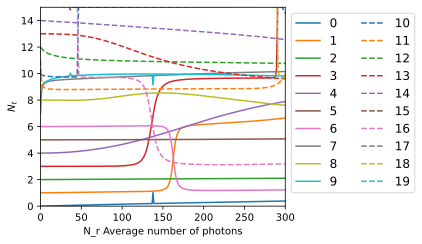

In [9]:
omega_d_idx = 0  # index for the first drive frequency
Chi = 1.2e-3#0.73e-3  # Chi in GHz
# chi = 0.012
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_values / Chi / 2 / np.pi,
        new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("N_r Average number of photons")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0, 15)  # Adjust x-axis limit for clarity
ax.set_xlim(0, 300)  # Adjust x-axis limit for clarity
plt.tight_layout()
plt.savefig("branch_analysis.pdf")
plt.show()

In [11]:
import numpy as np
import qutip as qt
import scqubits as scq
import floquet as ft

# Define two transmons
num_states = 10
qubit1 = scq.Transmon(EJ=18.0, EC=0.19, ng=0.0, ncut=41, truncated_dim=num_states)
qubit2 = scq.Transmon(EJ=15.0, EC=0.21, ng=0.0, ncut=41, truncated_dim=num_states)

# Build Hilbert space
hilbert_space = scq.HilbertSpace([qubit1, qubit2])
hilbert_space.generate_lookup()

# Get joint eigenvalues
evals = hilbert_space["evals"][0][:num_states**2]
H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))

# Example: sum of n_operators for both qubits as drive operator
n_op1 = hilbert_space.op_in_dressed_eigenbasis(qubit1.n_operator)
n_op2 = hilbert_space.op_in_dressed_eigenbasis(qubit2.n_operator)
H1 = n_op1 + n_op2

# Drive parameters
omega_d_values = 2.0 * np.pi * np.linspace(7.0, 10.0, 1)
chi_ac_values = 2.0 * np.pi * np.linspace(0.0, 0.5, 100)
state_indices = [0, 1, num_states, num_states+1]  # Example: ground and first excited for both

chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_values)
drive_amplitudes = chi_to_amp.amplitudes_for_omega_d(chi_ac_values)

model = ft.Model(
    H0, H1, omega_d_values=omega_d_values, drive_amplitudes=drive_amplitudes
)

options = ft.Options(
    fit_range_fraction=0.5,
    floquet_sampling_time_fraction=0.0,
    fit_cutoff=4,
    overlap_cutoff=0.8,
    nsteps=30_000,
    num_cpus=6,
    save_floquet_modes=True,
)

floquet_analysis = ft.FloquetAnalysis(model, state_indices=state_indices, options=options)
data_vals = floquet_analysis.run(filepath="two_qubit_floquet_out.h5")

# ...branch analysis as before...

 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: overflow encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: invalid value encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199

Running floquet simulation with parameters: 
model: H0: Quantum object: dims=[[100], [100]], shape=(100, 100), type='oper', dtype=Dense, isherm=True
Qobj data =
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.          30.15948148   0.         ...   0.           0.
    0.        ]
 [  0.           0.          31.62337013 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 411.56237113   0.
    0.        ]
 [  0.           0.           0.         ...   0.         422.98075195
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  450.03991057]]
H1: Quantum object: dims=[[100], [100]], shape=(100, 100), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.00000000e+00 -1.19504993e+00 -1.28655919e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.19504993e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.28655919e+00  0.00000000e+00 

ValueError: x and y must have same first dimension, but have shapes (100,) and (400,)

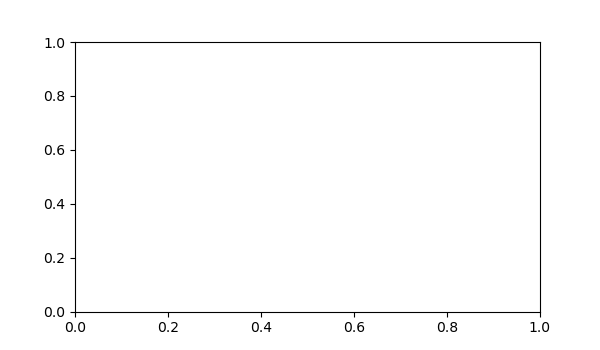

In [13]:
omega_d_idx = 0  # index for the first drive frequency
Chi = 1.2e-3  # Example value for normalization (GHz)

fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_values / Chi / 2 / np.pi,
        new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
        label=f"Branch {curve_idx}",
        **sty,
    )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("N$_r$ Average number of photons")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0, 15)
ax.set_xlim(0, 100)
plt.tight_layout()
plt.savefig("two_qubit_branch_analysis.pdf")
plt.show()